# MGS TES Tutorial With Visualization (Also Mini Python Tutorial)

## Overview

In hopes to make the development process easier on everyone involved, functions for processing TES data are part of a library located in the MGS TES repository (https://github.com/USGS-Astrogeology/mgs_tes_data). The library is called pytes which includes a number of convenince functions for working with TES Data both from the database and in memory.
The vverall workflow is:

1. query the database: get in-memory dataframes
2. group the data: Group the dataframes on some desired parameters (e.g. group by some time step)
3. reduce: Apply operations to reduce the data (e.g. subtract images)
4. analyzie: Produce graphs from the reduced data


## Import The Libraries We Need


First we import the necessary libraries for out work. Here we are using the following libraries (might want to get used to hearing these names around)

* pytes - The library for working with the MGS TES data
* shapely - A shape library, allows us to easily create different kind of shapes. Used for spatial queries.
* numpy - Super fast number crunching library, useful for performing math on large arrays
* matplotlib - Plotting library, histograms, line plots, etc.

In [2]:
# Press shift + enter to run this cell

# import everything we need to work with the data
import pytes

# import shapely stuff for spatial queries
from shapely.geometry import box
from shapely.geometry import Point

# numpy + pandas for number crunching
import numpy as np
import pandas as pd
import geopandas as gpd

# matplotlib for custom plotting
import matplotlib.pyplot as plt


# Listing Library Functions

Python has two very useful ways of determining what functions are avaialable to you.

dir() can be used to get a list of every function unside a library.

In [7]:
print('You can Basically ignore anything starting with underscores')
dir(pytes)

You can Basically ignore anything starting with underscores


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'connect_postgres',
 'get_images',
 'graph_images',
 'group_by',
 'io',
 'plot_hist',
 'plot_kde',
 'query_postgres',
 'spatial_query',
 'vis']

# Getting Info for Specific Function

If you want to learn more about a particular function (inputs, outputs and basic functionality) you can append ? to the end of the function name.

In [12]:
print('Adding "?" gives you function information')
print('Here, I am getting info on pytes.connect_postgres ...')

# pytes.connect_postgres?
pytes.query_postgres?

Adding "?" gives you function information
Here, I am getting info on pytes.connect_postgres ...


# Connect To The Database

pytes.connect_postgres is used to connect to the PostgreSQL database. It returns two objects, one the engine which represents your connection and metadata which has extra info on the database.

Whenever you want to query the database, you will have to pass in engine.

If you want to know more about the database (e.g. table listing) you can use the metadata. Although this is for more advanced use cases. 90% of the time you will be using pytes.query_postgres

In [3]:
engine,meta = pytes.connect_postgres(host='dcos-node1', port=24418)

In [10]:
# meta.tables is a dictionary, the keys are tables names
list(meta.tables.keys())

['testbin25time',
 'global_y25',
 'bin01time',
 'spatial_ref_sys',
 'tiy25',
 'pos',
 'bol',
 'test_ti',
 'marsti',
 'test_net',
 'obs',
 'ifg',
 'geo',
 'atm',
 'rad2',
 'test']

## Load into Memory (Also Basic Use of Pandas DataFrames)

Now that we have our `engine`, we can use it to get some dataframes (basically in-memory tables). `pytes.query_postgres` needs to have the DB engine passed into the function so it knows which database to grab the data from. Other parameters are used to constrain the query. 

Parameters:
* `conn` - This is almost always going to be the `engine` returned by `pytes.connect_postgres`. 
* `columns` - If you want to contrain the columns you want, input it here as a list of strings. 
* `shape` - generally a tuple in the format (minx, miny, maxx, maxy). In more advanced use cases, you can use a shapley object (more on that later)
* `year` - year range wanted
* `ls` - Ls range wanted
* `local_time` - local_time range wanted
* `verbose` - if true, prints out the exact query being executed

It returns a Pandas DataFrame. 

>**REMEMBER** You can always do `pytes.query_postgres?` to get a more technical description 


In [8]:
# Without any parameters, you get a global view
# This query takes a while...
globaldf = pytes.query_postgres(engine)

# df is the dataframe, .head() allows us to peak at the first 5 records.
globaldf.head(5)

,row,col,geom,ti,year,lsubs,local_time
0,1,1,"POLYGON ((0 -90, 0 -89, 1 -89, 1 -90, 0 -90))",0.0,25,74.0,9.0
1,1,1,"POLYGON ((0 -90, 0 -89, 1 -89, 1 -90, 0 -90))",0.0,25,74.0,17.0
2,1,1,"POLYGON ((0 -90, 0 -89, 1 -89, 1 -90, 0 -90))",0.0,25,74.0,19.0
3,1,1,"POLYGON ((0 -90, 0 -89, 1 -89, 1 -90, 0 -90))",0.0,25,75.0,21.0
4,2,1,"POLYGON ((0 -89, 0 -88, 1 -88, 1 -89, 0 -89))",0.0,25,42.0,12.0


In [5]:
# output some basic statictics, but we only want min, max and mean
globaldf.describe().loc[['min', 'max', 'mean']]

,row,col,ti,year,lsubs,local_time
min,1.000000,1.00000,0.000000,24.000000,0.000000,0.000000
max,180.000000,360.00000,800.000000,27.000000,360.000000,23.000000
mean,87.345616,180.36314,129.230331,25.223385,173.697511,4.789247


## Year/Ls Range

Python's [`range`](https://docs.python.org/3/library/functions.html#func-range) function is very useful for obtaining ranges of values. 

* Use `range` when you want to select a range from a particular parameter (e.g. year and Ls). 
* Using lists for a discrete values also work.
* `verbose = True` prints out the complete query (if you care for that sort of thing, mostly for debugging)


In [6]:
# use key=value syntax for specific parameters, no need to memorize parameter order
# range is [start, stop)
#globaldf = pytes.query_postgres(engine, ls=range(0,181), year=range(25,26))

global_reg = pytes.query_postgres(engine, ls=range(0,30), year=range(24,27))

# Take a quick peak
globaldf.head(5)

,row,col,geom,ti,year,lsubs,local_time
0,3,1,"POLYGON ((0 -88, 0 -87, 1 -87, 1 -88, 0 -88))",800.0,25,9.0,19.0
1,3,1,"POLYGON ((0 -88, 0 -87, 1 -87, 1 -88, 0 -88))",800.0,25,10.0,19.0
2,3,1,"POLYGON ((0 -88, 0 -87, 1 -87, 1 -88, 0 -88))",0.0,25,21.0,18.0
3,3,1,"POLYGON ((0 -88, 0 -87, 1 -87, 1 -88, 0 -88))",0.0,25,22.0,19.0
4,3,1,"POLYGON ((0 -88, 0 -87, 1 -87, 1 -88, 0 -88))",0.0,25,23.0,19.0


In [7]:
# output some basic statictics, but we only want min, max and mean
globaldf.describe().loc[['min', 'max', 'mean']]

,row,col,ti,year,lsubs,local_time
min,1.000000,1.000000,0.000000,24.000000,0.00000,0.00000
max,173.000000,360.000000,800.000000,27.000000,30.00000,23.00000
mean,68.149625,180.197904,172.523877,26.067828,15.81885,4.68749


## Spatial Query + Visualizing Images

For spatial queries, we leverage python library `shapely` quite often. We can use shapely to produce arbitrary shapes for performing spatial queries. 

* `shapely.box` allows you to create a Box shape from bounds (i.e. Box(minx, miny, maxx, maxy))
* `shapely.point` creates a point, but adding a buffer creates a circle

The bouds of the shape are used in the actual queries (also, getting a circular image didn't seem very useful)

Passing a list of DataFrames into `pytes.get_images` transforms it into a list of images. Images in this case are simply 2D arrays of TI values. 

These images can be piped into `pytes.graph_images` to be visualized

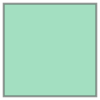

In [23]:
box(0, 0, 1, 1)

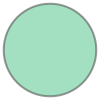

In [24]:
Point(134.4, 20).buffer(7.0)

In [25]:
# The shape keyword arg is used to specify the location of interest
#zoomdf = pytes.query_postgres(engine, shape=Point(134.4, 20).buffer(7.0))

zoomdf = pytes.query_postgres(engine, shape=Point(134.4, 20).buffer(7.0))

zoomdf.head(5)

,row,col,geom,ti,year,lsubs,local_time
0,413,511,"POLYGON ((127.5 13, 127.5 13.25, 127.75 13.25,...",24.000000,24,113.0,2.0
1,413,511,"POLYGON ((127.5 13, 127.5 13.25, 127.75 13.25,...",77.380000,24,160.0,2.0
2,413,511,"POLYGON ((127.5 13, 127.5 13.25, 127.75 13.25,...",41.353077,24,175.0,2.0
3,413,511,"POLYGON ((127.5 13, 127.5 13.25, 127.75 13.25,...",60.233333,24,190.0,2.0
4,413,511,"POLYGON ((127.5 13, 127.5 13.25, 127.75 13.25,...",85.665001,24,210.0,2.0


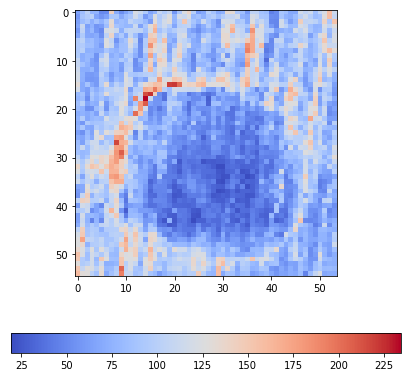

In [ ]:
# We need to get the images before we can plot them
#img = pytes.get_images([zoomdf])

img = pytes.get_images([globaldf)

pytes.graph_images(img[0])

## Basic Pandas Operations


**Queries**

You can continue to reduce the dataframe by performing operations on the dataframe. Any dataframe has a query funtion which accepts strings representing a query. In the most trivial case, these strings are simple equality statements.

* Strings use columns names which are applied on the column
* df.query returns a new dataframe, makes sure to store it somewhere!

**plots**

Columns can be selected similar to dictionary key-value pairs. This is useful for applying operations on a column as if they were 1-D arrays. One simple function useful here is to plot data. 

In [ ]:
# Get all points where ti is between 25 and 300 whatever-TI-is-measured-in (can't be bothered to look it up)
querydf = zoomdf.query('ti >= 25 & ti <= 200')
querydf['ti'].plot.hist()

# after plotting things manually, run this line to display it
plt.show()

In [36]:
## Robin can change this group - this data frame feeds into the get_images command below and sets the year and lsubs
## ranges I am interested in visualizing.
#dataframes = pytes.group_by(globaldf, lsubs=91)

#dataframes = pytes.group_by(globaldf, lsubs=31, year=1)

dataframes = pytes.group_by(globaldf.query('year==24 | year==26'), lsubs=31)

print('Number of dataframes created:', len(dataframes))

Number of dataframes created: 12


In [20]:
pytes.group_by?

In [37]:
# Generate images like before
# images = pytes.get_images(dataframes)

images = pytes.get_images(dataframes)

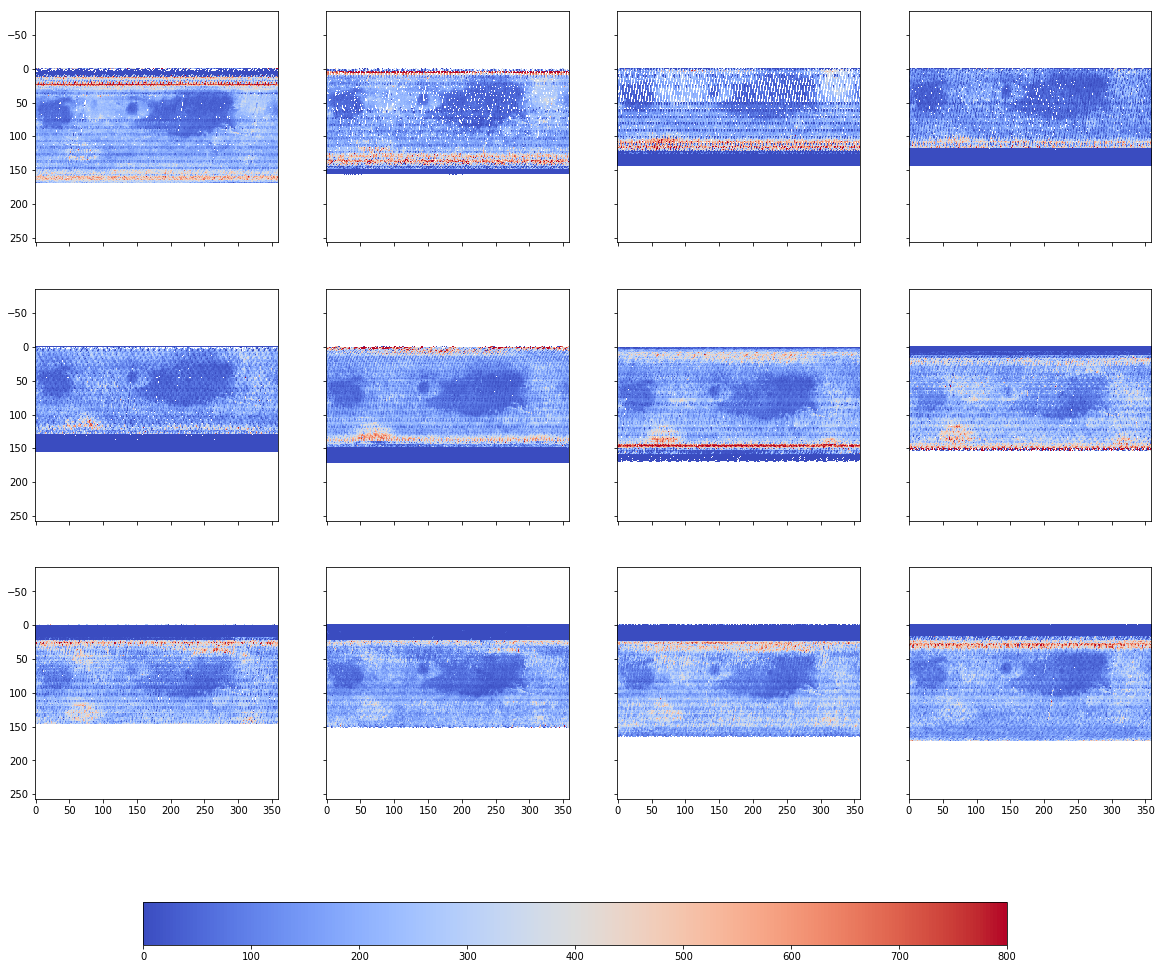

In [38]:
pytes.graph_images(images[0:12])

## Diffing Images

Since images are numpy arrays, we can leverage numpy operations as necessary. Diffing two numpy arrays can be done by simply using the subraction operator.

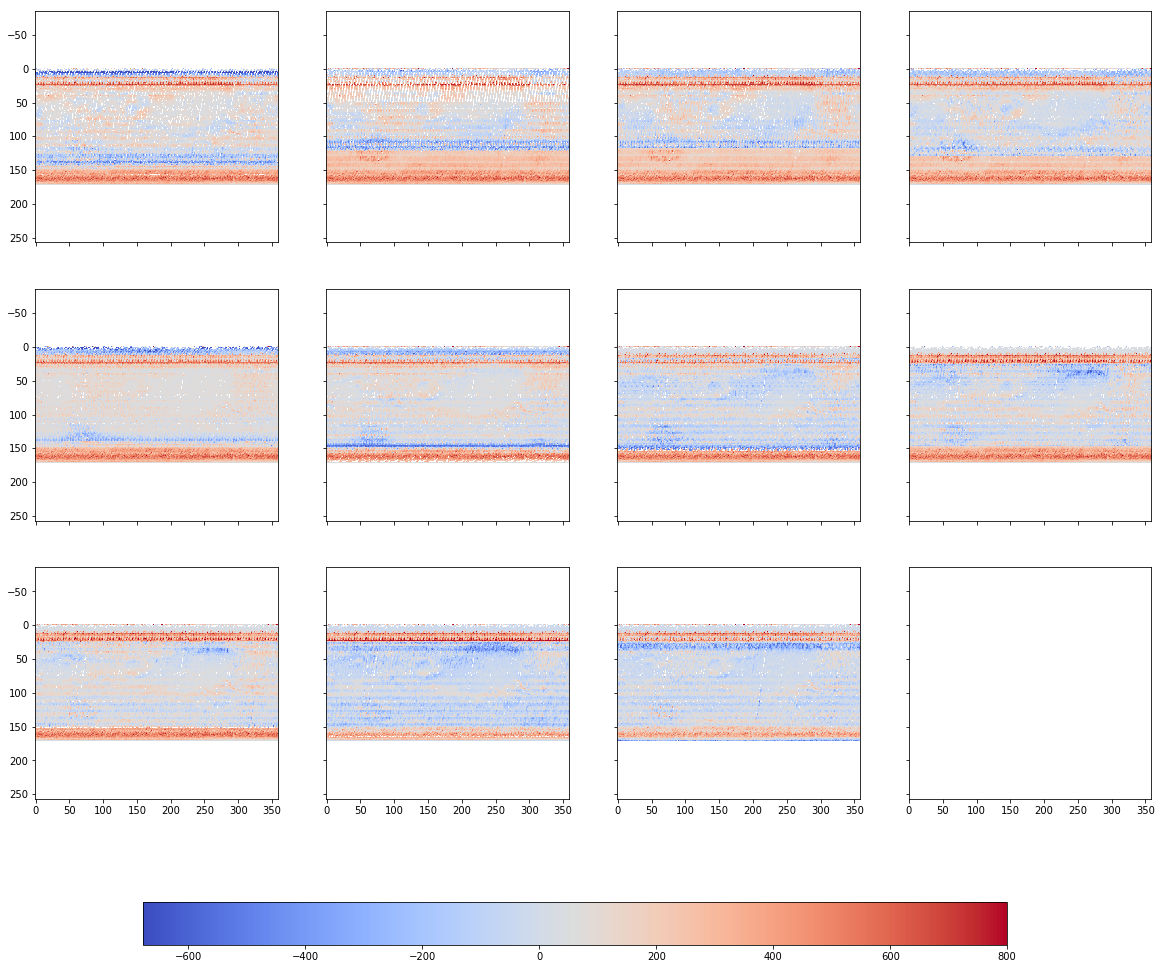

In [51]:
images = reshape(images)

# Standard list indexing can be used to get a particular image
img1 = images[0]    # Year 24 and 26; Ls 0-30
img2 = images[1]    # Year 24 and 26; Ls 30-60
img3 = images[2]    # Year 24 and 26; Ls 60-90
img4 = images[3]    # Year 24 and 26; Ls 90-120
img5 = images[4]    # Year 24 and 26; Ls 120-150
img6 = images[5]    # Year 24 and 26; Ls 150-180
img7 = images[6]    # Year 24 and 26; Ls 180-210
img8 = images[7]    # Year 24 and 26; Ls 210-240
img9 = images[8]    # Year 24 and 26; Ls 240-270
img10 = images[9]    # Year 24 and 26; Ls 270-300
img11 = images[10]    # Year 24 and 26; Ls 300-330
img12 = images[11]    # Year 24 and 26; Ls 330-360

# Subtracting two images returns a new image like any other use of `-`
diff1_2 = img1-img2
diff1_3 = img1-img3
diff1_4 = img1-img4
diff1_5 = img1-img5
diff1_6 = img1-img6
diff1_7 = img1-img7
diff1_8 = img1-img8
diff1_9 = img1-img9
diff1_10 = img1-img10
diff1_11 = img1-img11
diff1_12 = img1-img12


image_list = [diff1_2, diff1_3, diff1_4, diff1_5, diff1_6, diff1_7, diff1_8, diff1_9, diff1_10, diff1_11, diff1_12]
pytes.graph_images(image_list)


# We can stuff the two images into a list to plot them at the same time
# image_list = [img1,img2]
# pytes.graph_images(image_list)
# pytes.graph_images(diff)

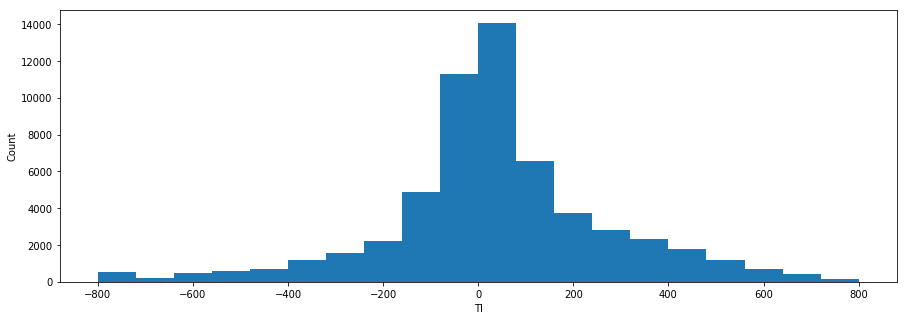

In [63]:
# output some basic statictics, but we only want min, max and mean
# globaldf.describe().loc[['min', 'max', 'mean']]

np.nanmin(diff1_2)
pytes.plot_hist(diff1_2, bins=20)

In [45]:
# With the zoomed in images 
zoomdfs = pytes.group_by(zoomdf, lsubs=90)
zoomimgs = pytes.get_images(zoomdfs)
pytes.graph_images(zoomimgs)

NameError: name 'zoomdf' is not defined

In [47]:
def reshape(images):
    maxshape = max([img.shape for img in images])
    new_images = []
    for img in images:
        rows = maxshape[0] - img.shape[0]
        cols = maxshape[1] - img.shape[1]
        for i in range(rows):
            img = np.vstack([img, np.zeros(img.shape[1] + cols)])
           
        new_images.append(img)
    return new_images

# # np.diff can subtract a list of images, out[n] = a[n+1] - a[n]
# reshaped = reshape(zoomimgs)
# diff_list = list(np.diff(zoomimgs[::-1], axis=0))

# print('White pixels are NaN values. The Sparse data sometimes causes NaN values.')

# # The colormap viridis makes it easier to notice some features
# pytes.graph_images(diff_list)

NameError: name 'zoomimgs' is not defined

## Plotting Stuff

Currently, the only plotting options are `pytest.plot_hist` and `pytes.plotkde`. Given an image or a list of images, it will plot a TI histogram/KDE respectively.

In [ ]:
zoomimgs = np.array(zoomimgs)
pytes.plot_hist(zoomimgs)
pytes.plot_hist(zoomimgs)
pytes.plot_hist(np.array(diff_list))
pytes.plot_kde(np.array(diff_list))

In [ ]:
pytes.graph_images(diff_list, vmin=-200, vmax=200)